# 0. Galaxy classification using fully-connected neural networks

In this notebook, we attempt to classify galaxies according to their shape using fully connected DNN.


The data in this example is a subset of the [Galaxy10 dataset](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/). The images are categorized according to their shapes. We use a slimmed down dataset which contains 8 classes:

'Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge'.


The aim of this work is to train a neural network to classify the galaxy images. 

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)


Using TensorFlow v2.7.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

The slimmed down dataset, which include the images with 8 labels, are stored in the h5 file `Astronomy/Galaxy8.h5`. We load this file using a `h5py` library.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])
```
    
</p>
</details>

In [4]:
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])

In [5]:
# downsample the images - so that the model fits in memory.
x = x[:, ::2, ::2]

# normalise images    
x = x / 255.0

# split train test
train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=0)


# string labels
string_labels = ['Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral',
                 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0, :, :, 0].shape))
print("Number of channels: %s" % str(train_images.shape[-1]))


Number of training data: 6400
Number of test data: 1600
Image pixels: (64, 64)
Number of channels: 3


### We can randomly plot some images and their labels

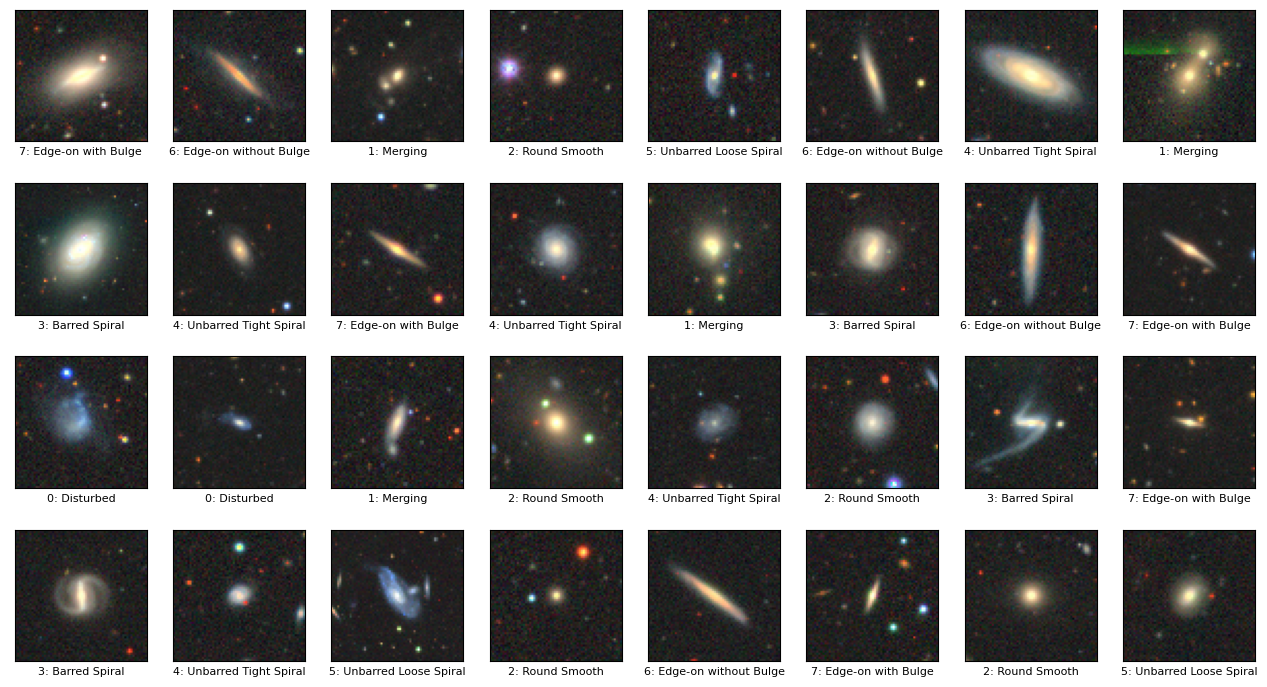

In [6]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata], label, nrows, ncols, iplot)
plt.show()

---

# 2. Build the network

In this case, we have 8 classes. Hence, the number of the outputs is 8. Then, we use 'SparseCategoricalCrossentropy' and will see 'accuracy' while training the model.



**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the network architecture
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()
```
    
</p>
</details>


In [7]:
# build the network architecture
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 1024)              12583936  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 12,716,168
Trainable params: 12,716,168
Non-trainable params: 0
_________________________________________________________________


2022-03-28 11:12:45.972783: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 11:12:46.544112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14773 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


### Compile and train the model

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# compile the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32, 
                             validation_data=(test_images, test_labels))
```
    
</p>
</details>

In [8]:
# compile the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32, 
                             validation_data=(test_images, test_labels))

Epoch 1/50
200/200 [==============================] - 2s 5ms/step - loss: 2.2215 - accuracy: 0.2044 - val_loss: 1.8870 - val_accuracy: 0.2412
Epoch 2/50
200/200 [==============================] - 1s 4ms/step - loss: 1.8319 - accuracy: 0.2777 - val_loss: 1.8228 - val_accuracy: 0.2950
Epoch 3/50
200/200 [==============================] - 1s 4ms/step - loss: 1.7327 - accuracy: 0.3256 - val_loss: 1.7831 - val_accuracy: 0.3006
Epoch 4/50
200/200 [==============================] - 1s 4ms/step - loss: 1.6271 - accuracy: 0.3717 - val_loss: 1.5704 - val_accuracy: 0.3938
Epoch 5/50
200/200 [==============================] - 1s 4ms/step - loss: 1.4628 - accuracy: 0.4411 - val_loss: 1.4442 - val_accuracy: 0.4500
Epoch 6/50
200/200 [==============================] - 1s 4ms/step - loss: 1.2967 - accuracy: 0.5102 - val_loss: 1.5331 - val_accuracy: 0.4069
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 1.1875 - accuracy: 0.5483 - val_loss: 1.3215 - val_accuracy: 0.5038
Epoch 

---

# 3. Analyse results 

### Check training history

We can examine the training history by plotting accuracy and loss against epoch for both the training and the test data. 

Notice that the accuracies for the training and the test data diverge as the model trains. This is a classic symptom of [overfitting](https://en.wikipedia.org/wiki/Overfitting), that is, our model corresponds too closely to the training data so that it cannot fit the test data with an equivalent accuracy.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

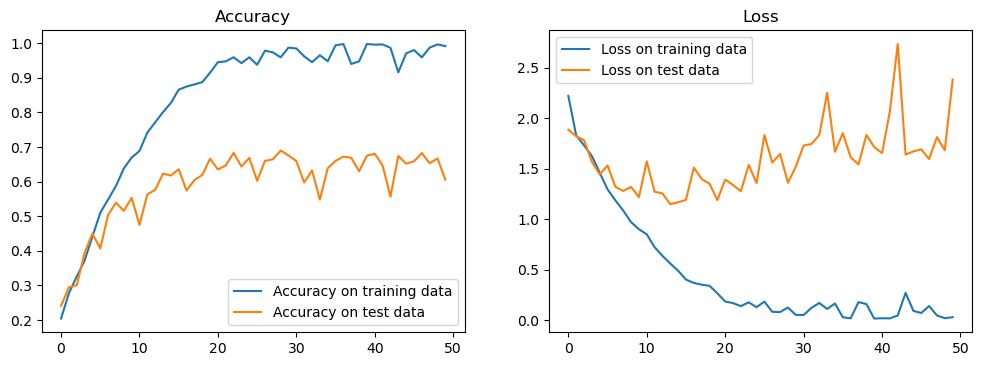

In [9]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

---

# 4. Regularise and re-train

Dropout, also called dilution, is a regularisation technique to mitigate against overfitting by randomly omitting a certain amount of neurons from a layer. Here we will rebuild our model with `Dropout` between the hidden and the output layers. Let us see whether this can negate the overfitting or not.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the network architecture
model_reg = Sequential()
model_reg.add(Flatten(input_shape=(64, 64, 3)))
model_reg.add(Dense(1024, activation='relu'))
model_reg.add(Dropout(0.1))
model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dense(8, activation='sigmoid'))

# compile the model
model_reg.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
```
    
</p>
</details>

In [11]:
# build the network architecture
model_reg = Sequential()
model_reg.add(Flatten(input_shape=(64, 64, 3)))
model_reg.add(Dense(1024, activation='relu'))
model_reg.add(Dropout(0.1))
model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dense(8, activation='sigmoid'))

# compile the model
model_reg.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

In [12]:
# train the model
training_history_reg = model_reg.fit(train_images, train_labels, epochs=50, batch_size=32, 
                                     validation_data=(test_images, test_labels))

Epoch 1/50
200/200 [==============================] - 1s 5ms/step - loss: 2.2427 - accuracy: 0.1641 - val_loss: 2.0241 - val_accuracy: 0.1606
Epoch 2/50
200/200 [==============================] - 1s 4ms/step - loss: 1.9701 - accuracy: 0.2220 - val_loss: 1.9105 - val_accuracy: 0.2387
Epoch 3/50
200/200 [==============================] - 1s 4ms/step - loss: 1.8673 - accuracy: 0.2627 - val_loss: 1.7980 - val_accuracy: 0.2906
Epoch 4/50
200/200 [==============================] - 1s 5ms/step - loss: 1.7754 - accuracy: 0.2897 - val_loss: 1.7576 - val_accuracy: 0.2862
Epoch 5/50
200/200 [==============================] - 1s 4ms/step - loss: 1.7022 - accuracy: 0.3266 - val_loss: 1.6820 - val_accuracy: 0.3206
Epoch 6/50
200/200 [==============================] - 1s 4ms/step - loss: 1.6080 - accuracy: 0.3603 - val_loss: 1.5306 - val_accuracy: 0.4187
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 1.4835 - accuracy: 0.4158 - val_loss: 1.4550 - val_accuracy: 0.4300
Epoch 

### Compare training histories with and without dropout

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history_reg.history[acc_str], label='Accuracy on training data')
plt.plot(training_history_reg.history['val_' + acc_str], label='Accuracy on test data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data (no dropout)')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history_reg.history['loss'], label='Loss on training data')
plt.plot(training_history_reg.history['val_loss'], label='Loss on test data')
plt.plot(training_history.history['val_loss'], label='Loss on test data (no dropout)')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

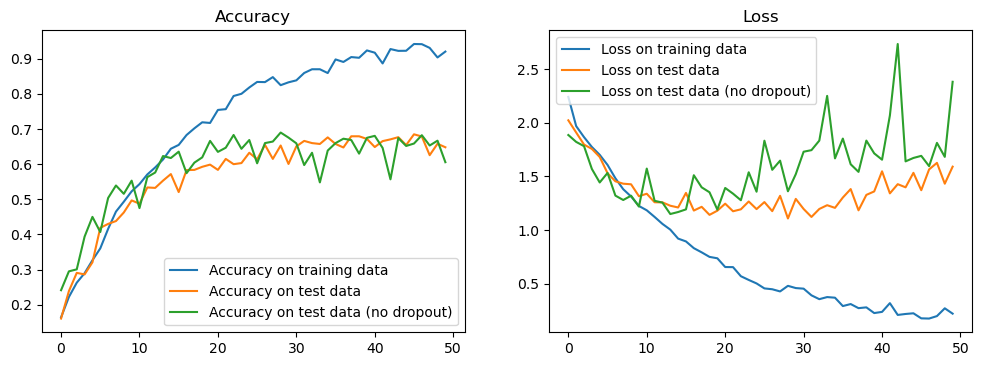

In [13]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history_reg.history[acc_str], label='Accuracy on training data')
plt.plot(training_history_reg.history['val_' + acc_str], label='Accuracy on test data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data (no dropout)')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history_reg.history['loss'], label='Loss on training data')
plt.plot(training_history_reg.history['val_loss'], label='Loss on test data')
plt.plot(training_history.history['val_loss'], label='Loss on test data (no dropout)')
plt.legend()
plt.title("Loss")
plt.show()

### Make predictions

Finally, we can use our trained model to make predictions. Here we show some wrong predictions for the test data, from which we may get some ideas about what kinds of images baffle our model.

In [14]:
# use test images to make predictions
pred_lables = model_reg.predict(test_images).argmax(axis=1)

Number of test data: 1600
Number of wrong predictions: 563


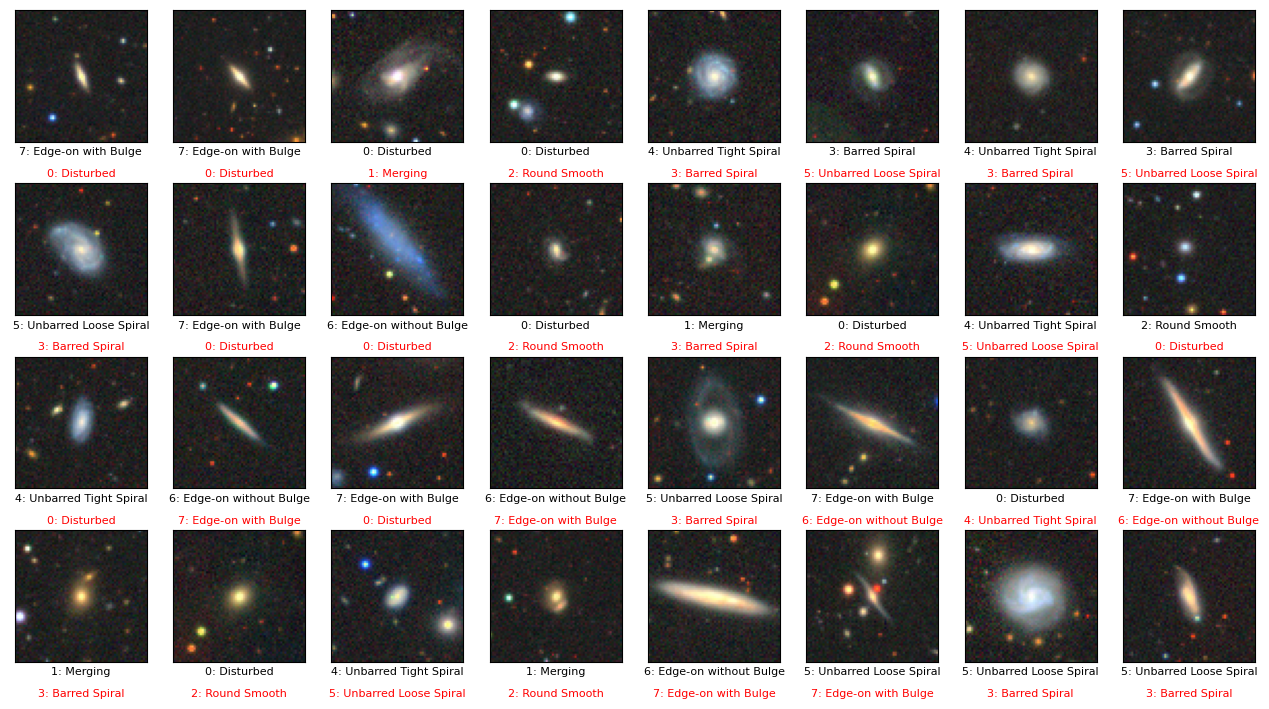

In [15]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != test_labels)[0]
print("Number of test data: %d" % test_labels.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (test_labels[idata], string_labels[test_labels[idata]])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(test_images[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

# 5. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Regularise the network and re-train